# 时间旅行

langgraph 可以使用Time Travel的能力来查看每个节点的历史状态，你还可以回到某个节点重新执行整个图

## 怎么使用

- 使用invoke 或者 stream方法传入参数来执行整个图

- 使用get_state_history() 方法来获取线程的执行历史

- 使用 update_state 方法可以来更新某个节点的状态

- 使用invoke或stream方法，输入为None，传入thread_id和checkpoint_id来继续执行

In [1]:
! pip install -U langgraph langchain_openai

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

chat_model = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME')
)


## 执行图

这是一个常见的agent执行流程

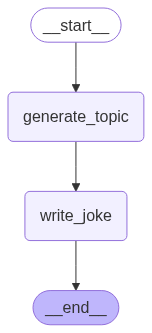

In [4]:
from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]


# 生成话题
def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = chat_model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}

# 编写笑话
def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = chat_model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

### 运行

In [5]:
config = {
    "configurable": {
        "thread_id": 1,
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

Why pigeons would make terrible Uber drivers: they only have one destination (your freshly washed car), panic at the word “hawk,” and tip *themselves* in breadcrumbs.

Q: Why don’t pigeons drive for Uber?  
A: Every ride ends at your freshly washed hood, they hit the eject button if you mutter “hawk,” and when it’s time to tip they just sprinkle breadcrumbs on themselves and flap away like you’re the weird one.


## 确定检查点

In [11]:
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print('state snapshot', state)
    print('---')

()
1f07b3ad-2c49-6f1c-8003-b8cfd704eba4
state snapshot StateSnapshot(values={'topic': 'chickens', 'joke': 'Why did the chicken stand in the middle of the road?  \nBecause it wanted to lay it on the line for once!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b3ad-2c49-6f1c-8003-b8cfd704eba4'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-17T07:21:42.290585+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b3a6-98a9-6c36-8002-818df45471ae'}}, tasks=(), interrupts=())
---
('write_joke',)
1f07b3a6-98a9-6c36-8002-818df45471ae
state snapshot StateSnapshot(values={'topic': 'chickens'}, next=('write_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b3a6-98a9-6c36-8002-818df45471ae'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2025-08-17T07:18:45.749656+00:00', parent_config={'configurable':

In [7]:
# 选择一个节点的状态
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'Why pigeons would make terrible Uber drivers: they only have one destination (your freshly washed car), panic at the word “hawk,” and tip *themselves* in breadcrumbs.'}


## 更新节点状态并重新执行

In [8]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07b3a6-98a9-6c36-8002-818df45471ae'}}


In [9]:
# 从节点处开始执行
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken stand in the middle of the road?  \nBecause it wanted to lay it on the line for once!'}